In [1]:
import random
from   os                import path
from   datetime          import datetime
import pandas            as pd
import numpy             as np
import matplotlib.pyplot as plt
import mplfinance        as mpf

from sklearn.preprocessing                    import MinMaxScaler
from ydata_synthetic.synthesizers             import ModelParameters
from ydata_synthetic.preprocessing.timeseries import processed_stock
from ydata_synthetic.synthesizers.timeseries  import TimeGAN

#np.random.seed(0)

In [2]:
asset = "btcusdt".upper()

df = pd.read_csv(f"./data/{asset}/{asset}-1m.csv", parse_dates=True, index_col="timestamp")
df = df.rename(columns={"op": "Open", "hi": "High", "lo":"Low", "cl":"Close", "volume": "Volume"})

df

,Open,High,Low,Close,Volume
timestamp,,,,,
2017-08-17 04:00:00+00:00,4261.48,4261.48,4261.48,4261.48,1.775183
2017-08-17 04:01:00+00:00,4261.48,4261.48,4261.48,4261.48,0.000000
2017-08-17 04:02:00+00:00,4280.56,4280.56,4280.56,4280.56,0.261074
2017-08-17 04:03:00+00:00,4261.48,4261.48,4261.48,4261.48,0.012008
2017-08-17 04:04:00+00:00,4261.48,4261.48,4261.48,4261.48,0.140796
...,...,...,...,...,...
2022-09-10 08:19:00+00:00,21313.24,21328.01,21309.41,21326.15,165.289480
2022-09-10 08:20:00+00:00,21326.75,21350.00,21325.37,21348.74,209.965260
2022-09-10 08:21:00+00:00,21348.74,21351.40,21328.66,21330.08,269.798810


In [3]:
def real_data_loading(data: np.array, seq_len):
    ori_data = data[::-1]
    scaler   = MinMaxScaler().fit(ori_data)
    ori_data = scaler.transform(ori_data)

    # Preprocess the dataset
    temp_data = []
    # Cut data by sequence length
    for i in range(0, len(ori_data) - seq_len):
        _x = ori_data[i:i + seq_len]
        temp_data.append(_x)

    # Mix the datasets (to make it similar to i.i.d)
    idx = np.random.permutation(len(temp_data))
    data = []
    for i in range(len(temp_data)):
        data.append(temp_data[idx[i]])

    return data, scaler

In [4]:
seq_len = 300

temp_processed, data_scaler = real_data_loading(data=df.values, seq_len=seq_len)

In [5]:
data_scaler

MinMaxScaler()

In [6]:
temp_processed[0].shape

(300, 5)

In [7]:
processed_size = len(temp_processed)

processed_size

2655412

In [8]:
train_samples_size = 100 #100000
random_numbers     = random.sample(range(0, processed_size), train_samples_size)
selected_indexes   = list(dict.fromkeys(random_numbers))

len(selected_indexes)

100

In [9]:
print(list(selected_indexes[:10]))

[1106307, 1245656, 1213325, 2390667, 504545, 1219230, 1146506, 1415226, 2041880, 2412993]


In [10]:
from tqdm import tqdm

In [11]:
downsampled_dataset = []

for idx in tqdm(selected_indexes):
    downsampled_dataset.append(temp_processed[idx])

100%|██████████| 100/100 [00:00<00:00, 269903.73it/s]


In [12]:
len(downsampled_dataset), downsampled_dataset[0].shape

(100, (300, 5))

In [13]:
#Specific to TimeGANs
n_feature     = 5  # ohlcv
hidden_dim    = 24
gamma         = 1

noise_dim     = 32
dim           = 128
batch_size    = 128

log_step      = 100
learning_rate = 5e-4

gan_args = ModelParameters(batch_size = batch_size,
                           lr         = learning_rate,
                           noise_dim  = noise_dim,
                           layers_dim = dim)

In [14]:
if path.exists('synthesizer_stock.pkl'):
    synth = TimeGAN.load('synthesizer_stock.pkl')
else:
    synth = TimeGAN(model_parameters=gan_args, hidden_dim=24, seq_len=seq_len, n_seq=n_feature, gamma=1)
    synth.train(downsampled_dataset, train_steps=400)
    synth.save('synthesizer_stock.pkl')

2022-09-22 13:19:52.788066: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-22 13:19:53.591026: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-22 13:19:53.592739: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-22 13:19:53.838166: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

2022-09-22 13:20:21.896203: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8401
2022-09-22 13:20:23.390360: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
Joint networks training:   0%|          | 0/400 [00:00<?, ?it/s]

Joint networks training: 100%|██████████| 400/400 [06:44<00:00,  1.01s/it]


In [15]:
synthetic_data = synth.sample(10)

synthetic_data

Synthetic data generation: 100%|██████████| 1/1 [00:00<00:00, 11.43it/s]


array([[[0.16896309, 0.15804683, 0.1645327 , 0.15891549, 0.0247926 ],
        [0.15385896, 0.15275803, 0.1573116 , 0.15930012, 0.00939818],
        [0.18114445, 0.18417637, 0.18163462, 0.18137892, 0.01026641],
        ...,
        [0.39295325, 0.38858384, 0.38890055, 0.3897103 , 0.01120717],
        [0.39091212, 0.38876775, 0.38992384, 0.3894989 , 0.01129471],
        [0.39542657, 0.39524332, 0.3970226 , 0.3956809 , 0.01134045]],

       [[0.14726843, 0.13519053, 0.14175245, 0.13554169, 0.02519427],
        [0.10561162, 0.09954071, 0.10854026, 0.10814661, 0.00876689],
        [0.09981254, 0.09532242, 0.09874316, 0.09782516, 0.00871896],
        ...,
        [0.5076353 , 0.50930756, 0.51127714, 0.5101184 , 0.01077571],
        [0.4957921 , 0.49565768, 0.4960949 , 0.49675888, 0.01077131],
        [0.46699986, 0.46395156, 0.4623149 , 0.4652858 , 0.01083165]],

       [[0.16913465, 0.15824564, 0.16470368, 0.15910779, 0.02478926],
        [0.15001194, 0.14827354, 0.15323758, 0.15502118, 0.0

In [16]:
synthetic_data.shape

(128, 300, 5)

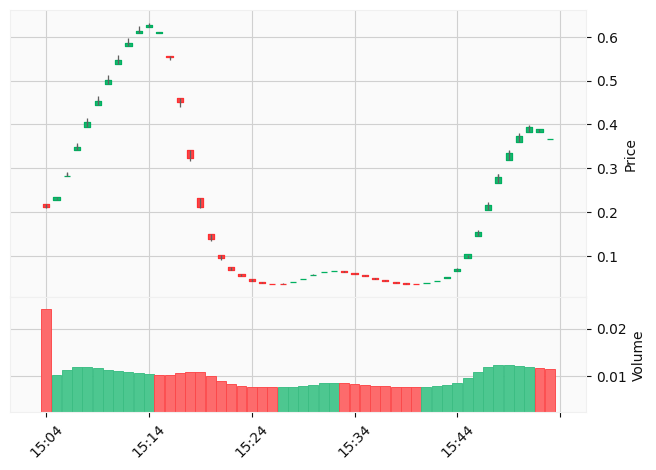

In [24]:
random_idx = np.random.randint(10)
scaled_data = synthetic_data[random_idx]
temp_df = pd.DataFrame(scaled_data[:50], columns=['Open', 'High', 'Low', 'Close', 'Volume'])

start_dt = datetime.strptime("6/8/2022 15:04:00.000000", "%d/%m/%Y %H:%M:%S.%f")
temp_df['datetime'] = [pd.to_datetime(start_dt+pd.DateOffset(minutes=offset)) for offset in range(0, len(temp_df))]

temp_df = temp_df.set_index(pd.DatetimeIndex(temp_df['datetime']))
temp_df = temp_df.drop(['datetime'], axis=1)

mpf.plot(temp_df, type='candle', style='yahoo', volume=True)

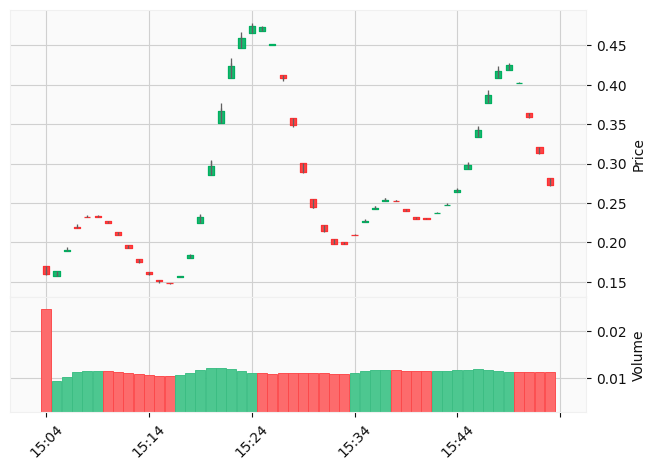

In [25]:
random_idx = np.random.randint(10)
scaled_data = synthetic_data[random_idx]
temp_df = pd.DataFrame(scaled_data[:50], columns=['Open', 'High', 'Low', 'Close', 'Volume'])

start_dt = datetime.strptime("6/8/2022 15:04:00.000000", "%d/%m/%Y %H:%M:%S.%f")
temp_df['datetime'] = [pd.to_datetime(start_dt+pd.DateOffset(minutes=offset)) for offset in range(0, len(temp_df))]

temp_df = temp_df.set_index(pd.DatetimeIndex(temp_df['datetime']))
temp_df = temp_df.drop(['datetime'], axis=1)

mpf.plot(temp_df, type='candle', style='yahoo', volume=True)

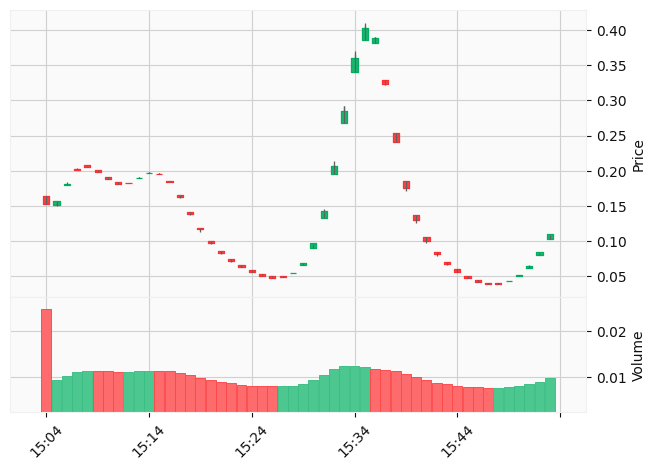

In [26]:
random_idx = np.random.randint(10)
scaled_data = synthetic_data[random_idx]
temp_df = pd.DataFrame(scaled_data[:50], columns=['Open', 'High', 'Low', 'Close', 'Volume'])

start_dt = datetime.strptime("6/8/2022 15:04:00.000000", "%d/%m/%Y %H:%M:%S.%f")
temp_df['datetime'] = [pd.to_datetime(start_dt+pd.DateOffset(minutes=offset)) for offset in range(0, len(temp_df))]

temp_df = temp_df.set_index(pd.DatetimeIndex(temp_df['datetime']))
temp_df = temp_df.drop(['datetime'], axis=1)

mpf.plot(temp_df, type='candle', style='yahoo', volume=True)

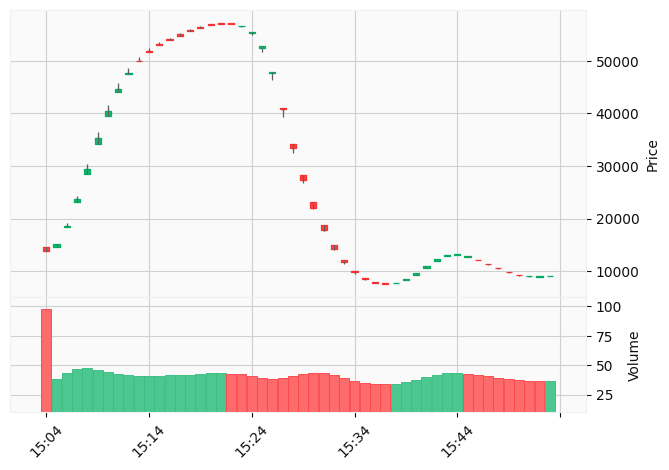

In [27]:
# Descaled chart
random_idx    = np.random.randint(10)
scaled_data   = synthetic_data[random_idx]
descaled_data = data_scaler.inverse_transform(scaled_data)

temp_df = pd.DataFrame(descaled_data[:50], columns=['Open', 'High', 'Low', 'Close', 'Volume'])

start_dt = datetime.strptime("6/8/2022 15:04:00.000000", "%d/%m/%Y %H:%M:%S.%f")
temp_df['datetime'] = [pd.to_datetime(start_dt+pd.DateOffset(minutes=offset)) for offset in range(0, len(temp_df))]

temp_df = temp_df.set_index(pd.DatetimeIndex(temp_df['datetime']))
temp_df = temp_df.drop(['datetime'], axis=1)

mpf.plot(temp_df, type='candle', style='yahoo', volume=True)

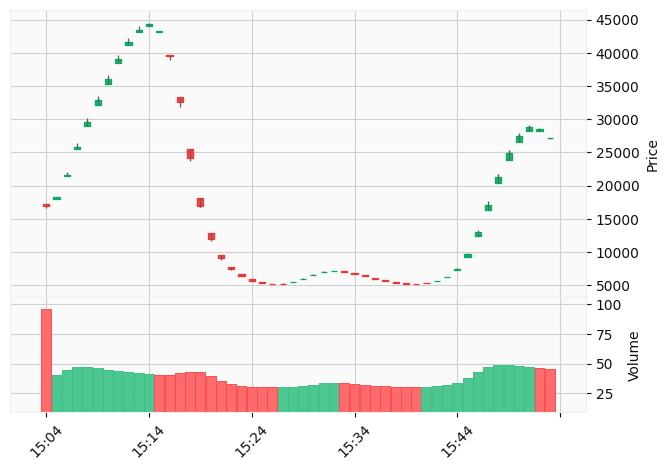

In [28]:
# Descaled chart
random_idx    = np.random.randint(10)
scaled_data   = synthetic_data[random_idx]
descaled_data = data_scaler.inverse_transform(scaled_data)

temp_df = pd.DataFrame(descaled_data[:50], columns=['Open', 'High', 'Low', 'Close', 'Volume'])

start_dt = datetime.strptime("6/8/2022 15:04:00.000000", "%d/%m/%Y %H:%M:%S.%f")
temp_df['datetime'] = [pd.to_datetime(start_dt+pd.DateOffset(minutes=offset)) for offset in range(0, len(temp_df))]

temp_df = temp_df.set_index(pd.DatetimeIndex(temp_df['datetime']))
temp_df = temp_df.drop(['datetime'], axis=1)

mpf.plot(temp_df, type='candle', style='yahoo', volume=True)

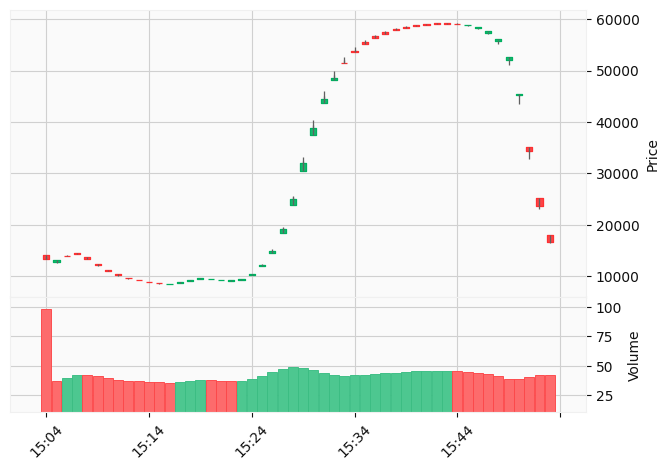

In [29]:
# Descaled chart
random_idx    = np.random.randint(10)
scaled_data   = synthetic_data[random_idx]
descaled_data = data_scaler.inverse_transform(scaled_data)

temp_df = pd.DataFrame(descaled_data[:50], columns=['Open', 'High', 'Low', 'Close', 'Volume'])

start_dt = datetime.strptime("6/8/2022 15:04:00.000000", "%d/%m/%Y %H:%M:%S.%f")
temp_df['datetime'] = [pd.to_datetime(start_dt+pd.DateOffset(minutes=offset)) for offset in range(0, len(temp_df))]

temp_df = temp_df.set_index(pd.DatetimeIndex(temp_df['datetime']))
temp_df = temp_df.drop(['datetime'], axis=1)

mpf.plot(temp_df, type='candle', style='yahoo', volume=True)

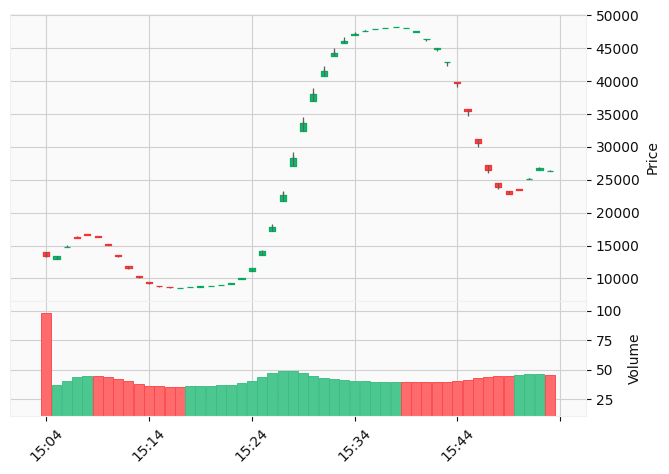

In [30]:
# Descaled chart
random_idx    = np.random.randint(10)
scaled_data   = synthetic_data[random_idx]
descaled_data = data_scaler.inverse_transform(scaled_data)

temp_df = pd.DataFrame(descaled_data[:50], columns=['Open', 'High', 'Low', 'Close', 'Volume'])

start_dt = datetime.strptime("6/8/2022 15:04:00.000000", "%d/%m/%Y %H:%M:%S.%f")
temp_df['datetime'] = [pd.to_datetime(start_dt+pd.DateOffset(minutes=offset)) for offset in range(0, len(temp_df))]

temp_df = temp_df.set_index(pd.DatetimeIndex(temp_df['datetime']))
temp_df = temp_df.drop(['datetime'], axis=1)

mpf.plot(temp_df, type='candle', style='yahoo', volume=True)